# EDA and Processing

In this notebook, I will be laoding and processing the images and masks used for semantic segmentation. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import cv2


from glob import glob
import os

2023-06-11 19:57:15.707484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Data

In [3]:
img_folder = '../semantic_drone_dataset/images/'
mask_folder = '../semantic_drone_dataset/label_images/'

In [4]:
img_files = np.sort(os.listdir(img_folder))
mask_files = np.sort(os.listdir(mask_folder))

In [14]:
def create_image_array(path, file_names: list):
    """
    Create list of images/masks loaded from dataset. Resizes data in the shape of 224 by 224, which is 
    the maximum size taken by the pre-trained model. 
    """
    images = []
    for file in file_names:
        img = cv2.imread(path+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_NEAREST )
        images.append(img)
        
    return images

In [15]:
# Load images and masks
images = create_image_array(img_folder, img_files)
masks = create_image_array(mask_folder, mask_files)

## Visualizing Data

In [16]:
def display(display_list, save_file: str):
  """
  Function used to display image with corresponding masks and mask predictions from model.
  """
  fig = plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  fig.savefig('../imgs/' + save_file)
  plt.show()

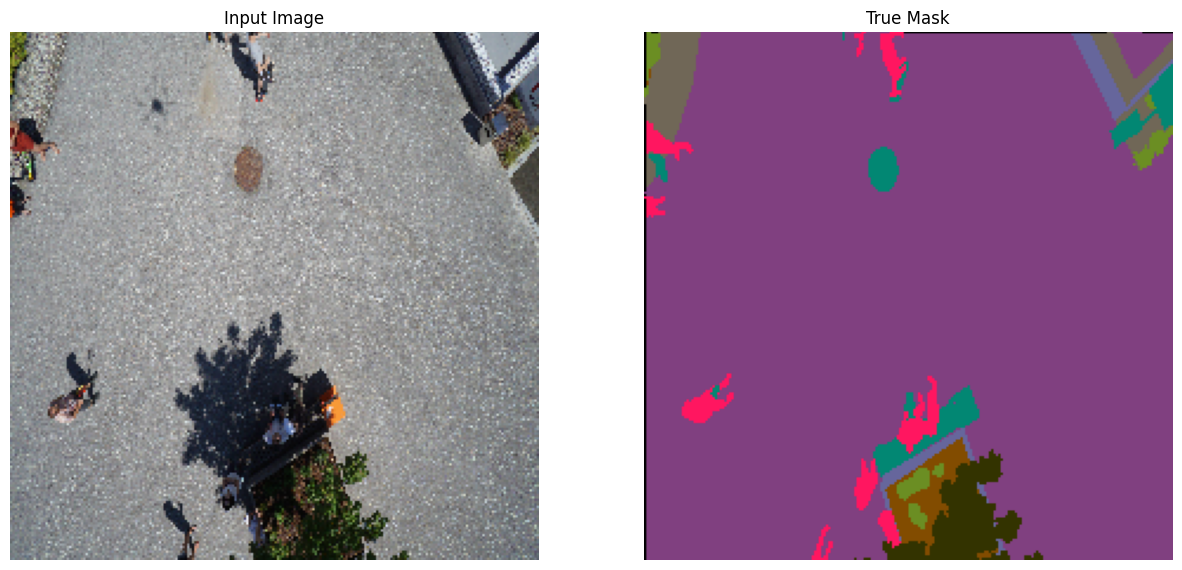

In [17]:
display([images[0], masks[0]], 'image_mask_pair.png')

## Preprocessing Data

For model training, the masks have to changed from the above 3-channel RGB mode to one where each pixel represents a class value. This is done using the functions below and a color map given my a csv file. The first function `mask_classes` creates the mask with pizel values of the class, while the second function reverts that operatoin. 

In [18]:
color_map = pd.read_csv('../semantic_drone_dataset/class_dict.csv')
dummy_color_map = pd.get_dummies(color_map, columns = ['name'], prefix='', prefix_sep='')
cm = color_map.iloc[:, 1:].T.to_dict()
cm_id = {tuple(v.values()): k for k, v in cm.items()}

def mask_classes(mask):
    shape = list(mask.shape[:2]) + [1]
    mask_class = np.zeros(shape, dtype=int)
    sub = lambda x: cm_id[tuple(x)]
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            mask_class[x,y,0] = sub(mask[x,y,:])
    return mask_class

In [19]:
cm_rgb = {int(k): tuple(v.values()) for k, v in cm.items()}

def mask_rgb(mask):
    shape = list(mask.shape[:2]) + [3]
    mask_class = np.zeros(shape, dtype=int)
    sub = lambda x: cm_rgb[int(x)]
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            mask_class[x,y,:] = sub(mask[x,y,0])
    return mask_class

In [20]:
masks_w_class = list(map(mask_classes, masks))

## Saving Data

After the images and masks have been resized and process, I will save them in the `processed` subfolder for use in the 
Modeling and Analysis steps.

In [21]:
img_save_folder = '../semantic_drone_dataset/processed/images/'
mask_save_folder = '../semantic_drone_dataset/processed/label_images/'

In [22]:
def save_image_array(path, images):
    for i, img in enumerate(images):
        file = f"{i:03d}" + '.png'
        cv2.imwrite(path+file, img)
    return

In [23]:
save_image_array(img_save_folder, images)

In [24]:
save_image_array(mask_save_folder, masks_w_class)